In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import warnings
warnings.filterwarnings(action = 'ignore')

# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

#### Dataset 불러오기

In [2]:
kospi_all = pd.read_csv('./dataset/data_kospi_all.csv')
kospi_bad = pd.read_csv('./dataset/data_kospi_bad.csv')
kospi_good = pd.read_csv('./dataset/data_kospi_good.csv')
kosdaq_all = pd.read_csv('./dataset/data_kosdaq_all.csv')
kosdaq_bad = pd.read_csv('./dataset/data_kosdaq_bad.csv')
kosdaq_good = pd.read_csv('./dataset/data_kosdaq_good.csv')

#### 함수

##### train, test 분리 + 데이터 불균형 처리 + 스케일링

In [3]:
def data(df):
    features = df.drop(['target'], axis=1)
    target = df[['target']]

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [4]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [5]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### Logistic Regression

In [6]:
def LG(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()
    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

##### Decision Tree

In [7]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [8]:
def DT_vis(df, best_model):
    export_graphviz(best_model.best_estimator_, out_file='bankruptcy.dot', class_names=["0", "1"], feature_names= df.drop(['target'], axis=1).columns, impurity=True, filled=True)

    with open('bankruptcy.dot', encoding='utf-8') as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)

##### SVM

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

##### XGBoost

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

____

#### 코스피

##### All

Logistic Regression

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.6316897425743571

예측 데이터 정확도
accuracy score : 0.623
precision score : 0.085
recall score : 0.436
f1 score : 0.143
roc score : 0.537
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11796    0.07438 0.98182   0.13828    0.51633
0.30000   0.22149    0.07956 0.92727   0.14655    0.54697
0.40000   0.40760    0.07676 0.65455   0.13740    0.52148
0.50000   0.62254    0.08541 0.43636   0.14286    0.53668
0.60000   0.79948    0.10484 0.23636   0.14525    0.53979
0.70000   0.88860    0.12500 0.09091   0.10526    0.52074
0.80000   0.91481    0.18750 0.05455   0.08451    0.51809
0.90000   0.92529    0.00000 0.00000   0.00000    0.49859
None


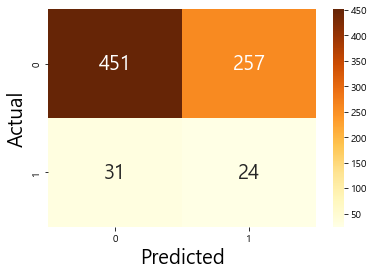

In [11]:
LG(kospi_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.7131680164971952

예측 데이터 정확도
accuracy score : 0.278
precision score : 0.072
recall score : 0.764
f1 score : 0.132
roc score : 0.502
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.26868    0.07155 0.76364   0.13084    0.49693
0.30000   0.27785    0.07241 0.76364   0.13228    0.50187
0.40000   0.27785    0.07241 0.76364   0.13228    0.50187
0.50000   0.27785    0.07241 0.76364   0.13228    0.50187
0.60000   0.89515    0.09677 0.05455   0.06977    0.50750
0.70000   0.89515    0.09677 0.05455   0.06977    0.50750
0.80000   0.91612    0.09091 0.01818   0.03030    0.50203
0.90000   0.91612    0.09091 0.01818   0.03030    0.50203
None


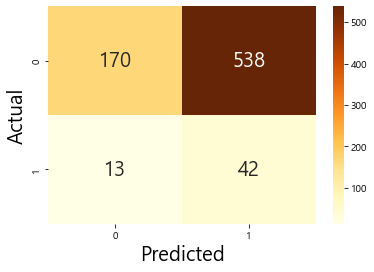

In [12]:
p_all = DT(kospi_all)

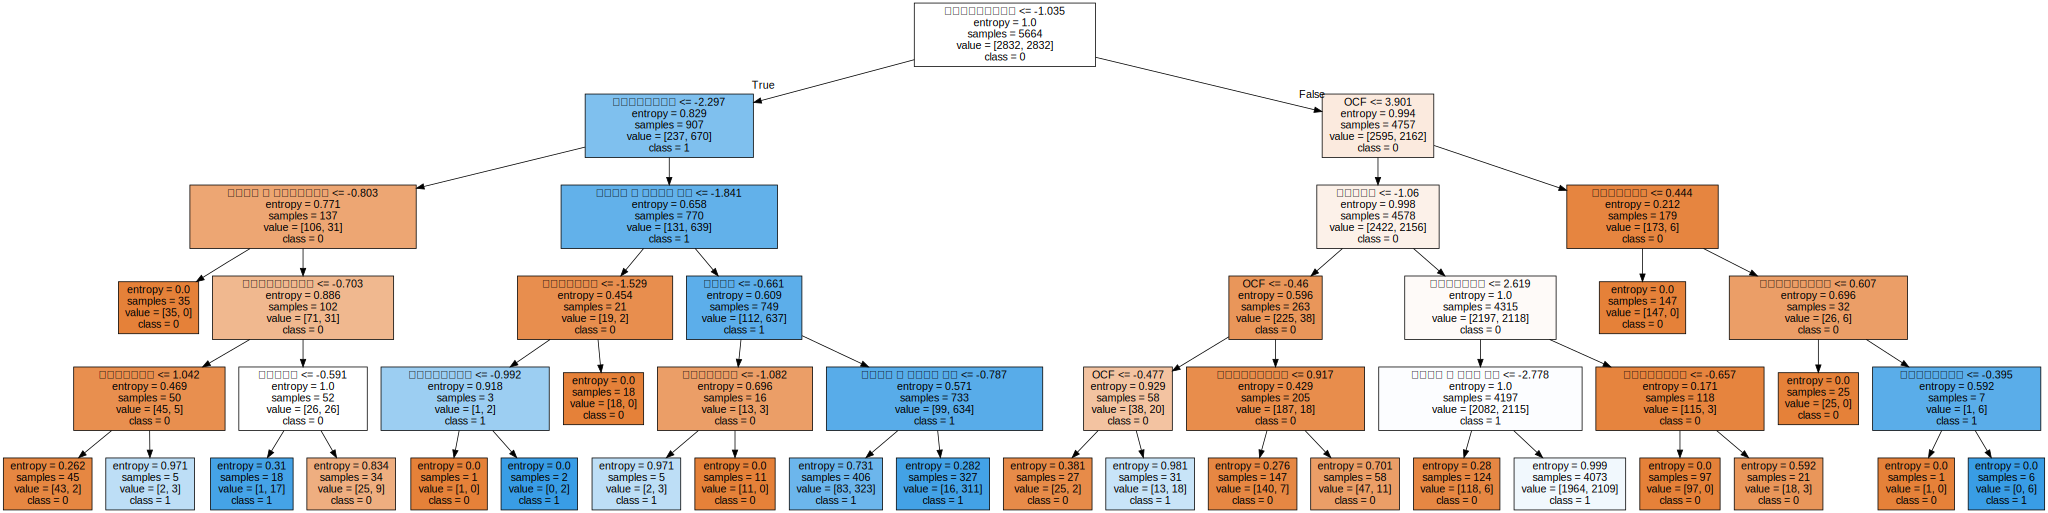

In [13]:
DT_vis(kospi_all, p_all)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9220047811377728

예측 데이터 정확도
accuracy score : 0.874
precision score : 0.023
recall score : 0.018
f1 score : 0.020
roc score : 0.479


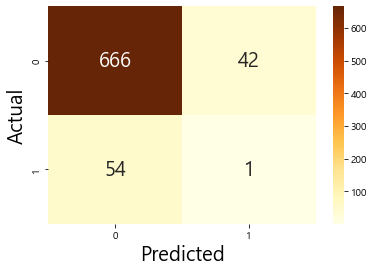

In [14]:
SVM(kospi_all, 'rbf')

In [15]:
# SVM(kospi_all, 'linear')

XGBoost

[23:23:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 12.967032967032967, 'silent': 1}
학습 데이터 정확도 :  0.9196239034563595

예측 데이터 정확도
accuracy score : 0.801
precision score : 0.099
recall score : 0.218
f1 score : 0.136
roc score : 0.532
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.66972    0.06222 0.25455   0.10000    0.47826
0.30000   0.71953    0.07487 0.25455 

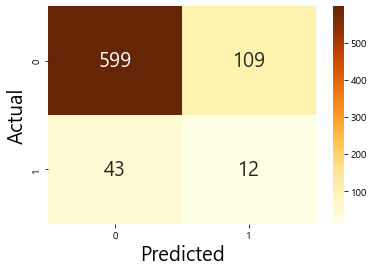

In [16]:
XGB(kospi_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.6034651056221206

예측 데이터 정확도
accuracy score : 0.601
precision score : 0.069
recall score : 0.528
f1 score : 0.122
roc score : 0.567
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.07569    0.05097 0.94444   0.09673    0.48605
0.30000   0.20378    0.05410 0.86111   0.10181    0.51427
0.40000   0.32460    0.06327 0.86111   0.11787    0.57802
0.50000   0.60116    0.06884 0.52778   0.12179    0.56650
0.60000   0.83552    0.05747 0.13889   0.08130    0.50646
0.70000   0.90830    0.06452 0.05556   0.05970    0.50550
0.80000   0.93450    0.15385 0.05556   0.08163    0.51933
0.90000   0.94760    0.00000 0.00000   0.00000    0.50000
None


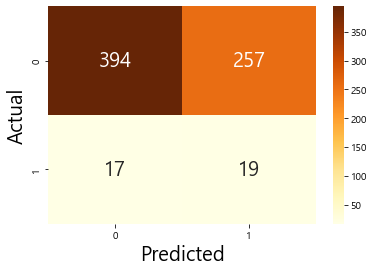

In [17]:
LG(kospi_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.7049742281472755

예측 데이터 정확도
accuracy score : 0.614
precision score : 0.054
recall score : 0.389
f1 score : 0.096
roc score : 0.508
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.32751    0.05439 0.72222   0.10117    0.51395
0.30000   0.32751    0.05439 0.72222   0.10117    0.51395
0.40000   0.32897    0.05451 0.72222   0.10136    0.51472
0.50000   0.61426    0.05447 0.38889   0.09556    0.50781
0.60000   0.88792    0.04444 0.05556   0.04938    0.49475
0.70000   0.88792    0.04444 0.05556   0.04938    0.49475
0.80000   0.89083    0.04651 0.05556   0.05063    0.49629
0.90000   0.94178    0.00000 0.00000   0.00000    0.49693
None


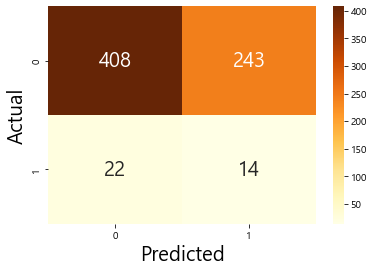

In [18]:
p_bad = DT(kospi_bad)

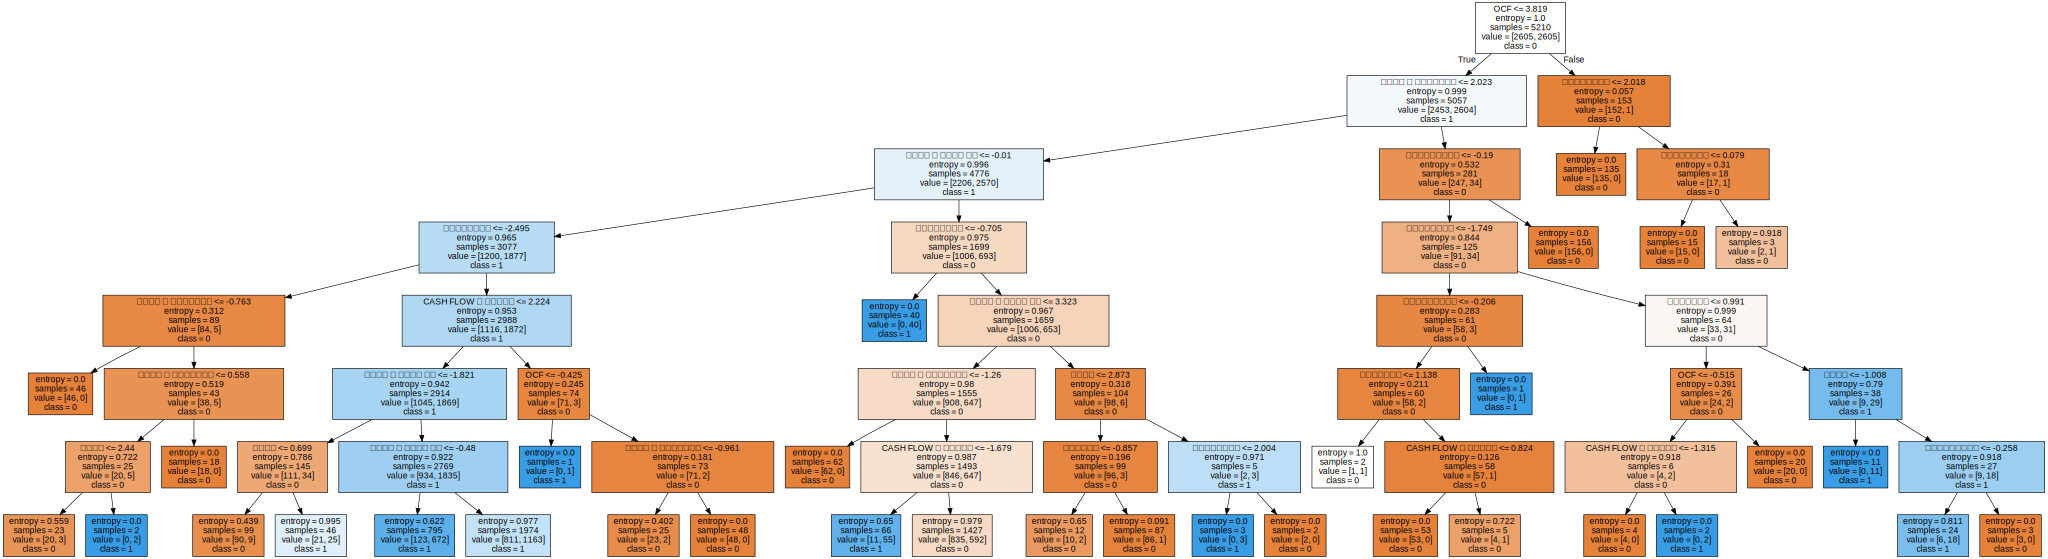

In [19]:
DT_vis(kospi_bad, p_bad)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9070727514339758

예측 데이터 정확도
accuracy score : 0.834
precision score : 0.067
recall score : 0.167
f1 score : 0.095
roc score : 0.519


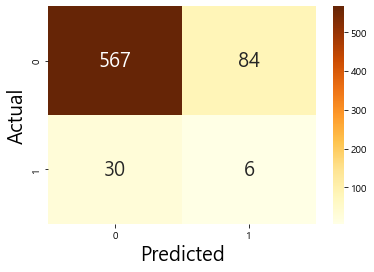

In [20]:
SVM(kospi_bad, 'rbf')

In [21]:
# SVM(kospi_bad, 'linear')

XGB

[23:29:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 18.189944134078214, 'silent': 1}
학습 데이터 정확도 :  0.9036277645011881

예측 데이터 정확도
accuracy score : 0.821
precision score : 0.078
recall score : 0.222
f1 score : 0.115
roc score : 0.538
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.70015    0.05729 0.30556   0.09649    0.51376
0.30000   0.76128    0.07333 0.30556 

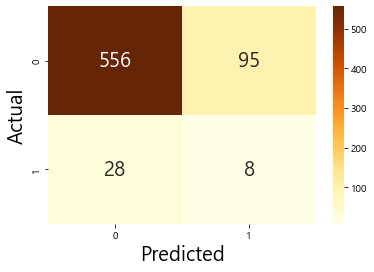

In [22]:
XGB(kospi_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.6136463851676833

예측 데이터 정확도
accuracy score : 0.671
precision score : 0.406
recall score : 0.684
f1 score : 0.510
roc score : 0.675
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.25000    0.25000 1.00000   0.40000    0.50000
0.30000   0.25000    0.25000 1.00000   0.40000    0.50000
0.40000   0.26316    0.25333 1.00000   0.40426    0.50877
0.50000   0.67105    0.40625 0.68421   0.50980    0.67544
0.60000   0.75000    0.00000 0.00000   0.00000    0.50000
0.70000   0.75000    0.00000 0.00000   0.00000    0.50000
0.80000   0.75000    0.00000 0.00000   0.00000    0.50000
0.90000   0.75000    0.00000 0.00000   0.00000    0.50000
None


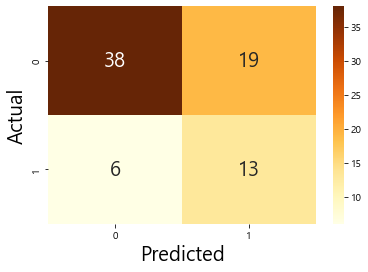

In [23]:
LG(kospi_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 5, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.7138889483459561

예측 데이터 정확도
accuracy score : 0.487
precision score : 0.237
recall score : 0.474
f1 score : 0.316
roc score : 0.482
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.47368    0.23077 0.47368   0.31034    0.47368
0.30000   0.48684    0.23684 0.47368   0.31579    0.48246
0.40000   0.48684    0.23684 0.47368   0.31579    0.48246
0.50000   0.48684    0.23684 0.47368   0.31579    0.48246
0.60000   0.48684    0.23684 0.47368   0.31579    0.48246
0.70000   0.51316    0.12500 0.15789   0.13953    0.39474
0.80000   0.64474    0.10000 0.05263   0.06897    0.44737
0.90000   0.64474    0.10000 0.05263   0.06897    0.44737
None


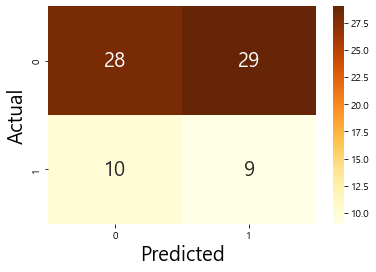

In [24]:
p_good = DT(kospi_good)

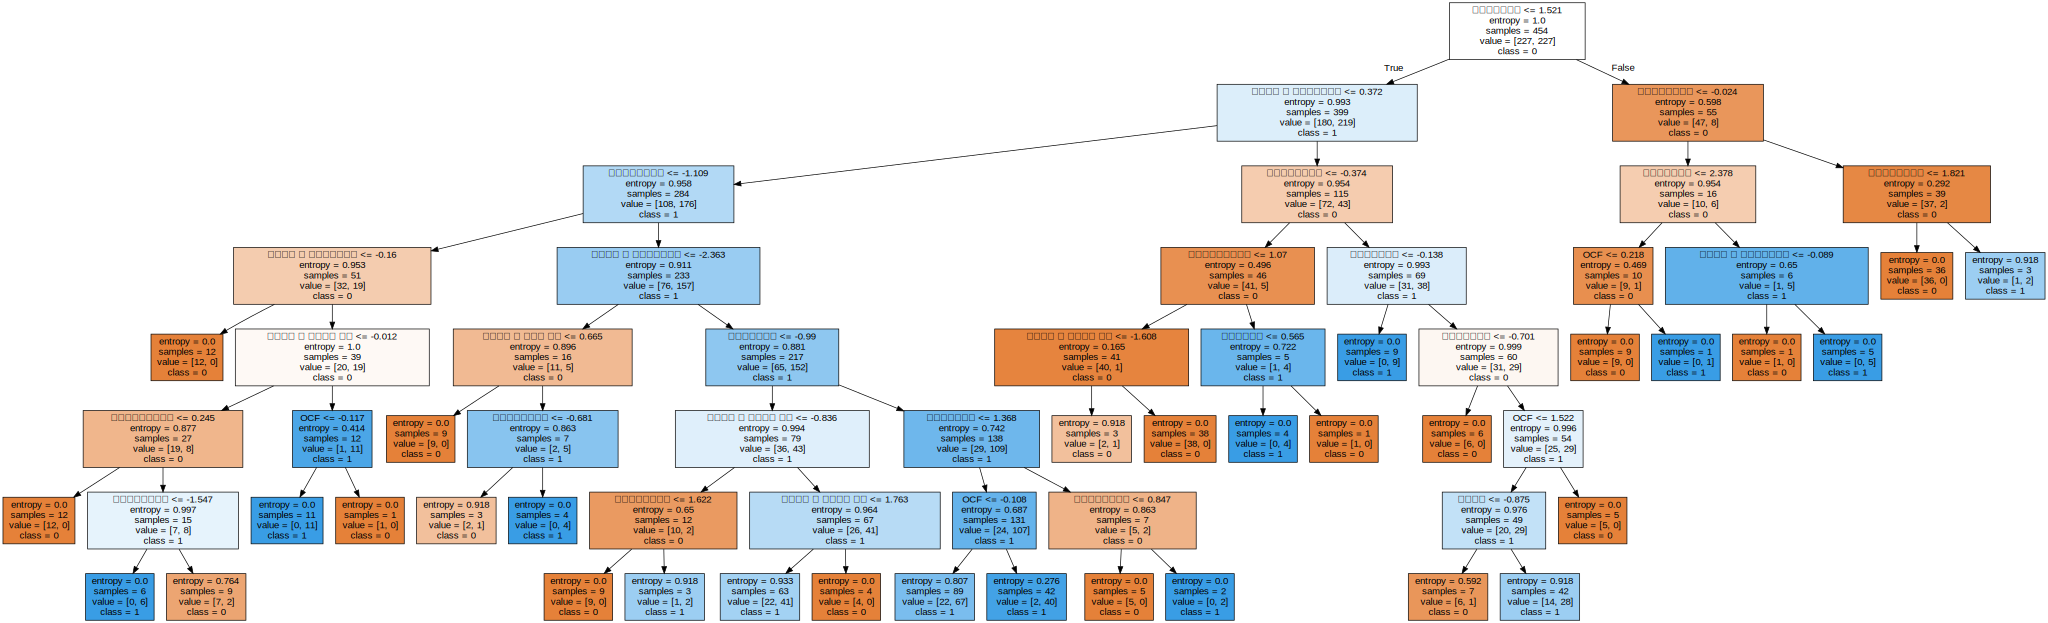

In [25]:
DT_vis(kospi_good, p_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8284251761830446

예측 데이터 정확도
accuracy score : 0.684
precision score : 0.308
recall score : 0.211
f1 score : 0.250
roc score : 0.526


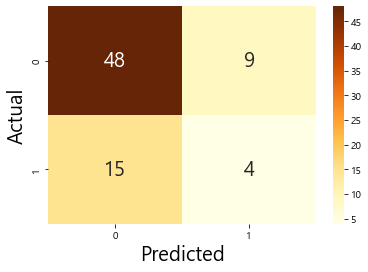

In [26]:
SVM(kospi_good, 'rbf')

In [27]:
# SVM(kospi_good, 'linear')

XGB

[23:30:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 3.021276595744681, 'silent': 1}
학습 데이터 정확도 :  0.7714370297212091

예측 데이터 정확도
accuracy score : 0.566
precision score : 0.281
recall score : 0.474
f1 score : 0.353
roc score : 0.535
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.52632    0.32653 0.84211   0.47059    0.63158
0.30000   0.56579    0.34091 0.78947 

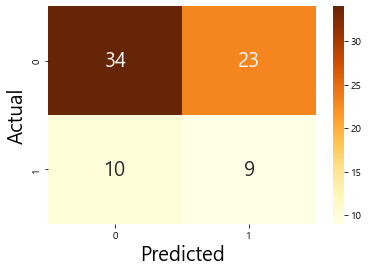

In [28]:
XGB(kospi_good)

#### 코스닥

##### ALL

Logistic Regression

최적 파라미터
 {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5393697020971155

예측 데이터 정확도
accuracy score : 0.543
precision score : 0.133
recall score : 0.569
f1 score : 0.215
roc score : 0.554
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.11002    0.11002 1.00000   0.19823    0.50000
0.30000   0.11002    0.11002 1.00000   0.19823    0.50000
0.40000   0.15921    0.11426 0.98374   0.20474    0.52051
0.50000   0.54293    0.13258 0.56911   0.21505    0.55440
0.60000   0.86225    0.26154 0.13821   0.18085    0.54499
0.70000   0.88909    0.00000 0.00000   0.00000    0.49950
0.80000   0.88998    0.00000 0.00000   0.00000    0.50000
0.90000   0.88998    0.00000 0.00000   0.00000    0.50000
None


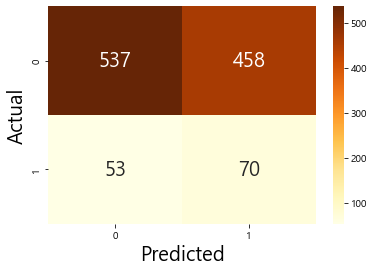

In [29]:
LG(kosdaq_all)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6738429772090206

예측 데이터 정확도
accuracy score : 0.268
precision score : 0.111
recall score : 0.805
f1 score : 0.195
roc score : 0.503
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.26834    0.11086 0.80488   0.19488    0.50344
0.30000   0.26834    0.11086 0.80488   0.19488    0.50344
0.40000   0.26834    0.11086 0.80488   0.19488    0.50344
0.50000   0.26834    0.11086 0.80488   0.19488    0.50344
0.60000   0.88551    0.00000 0.00000   0.00000    0.49749
0.70000   0.88551    0.00000 0.00000   0.00000    0.49749
0.80000   0.88730    0.00000 0.00000   0.00000    0.49849
0.90000   0.88730    0.00000 0.00000   0.00000    0.49849
None


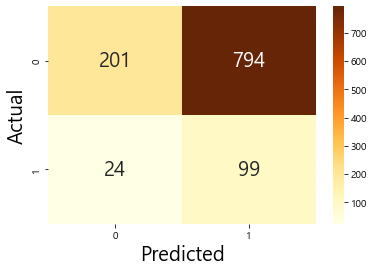

In [30]:
d_all = DT(kosdaq_all)

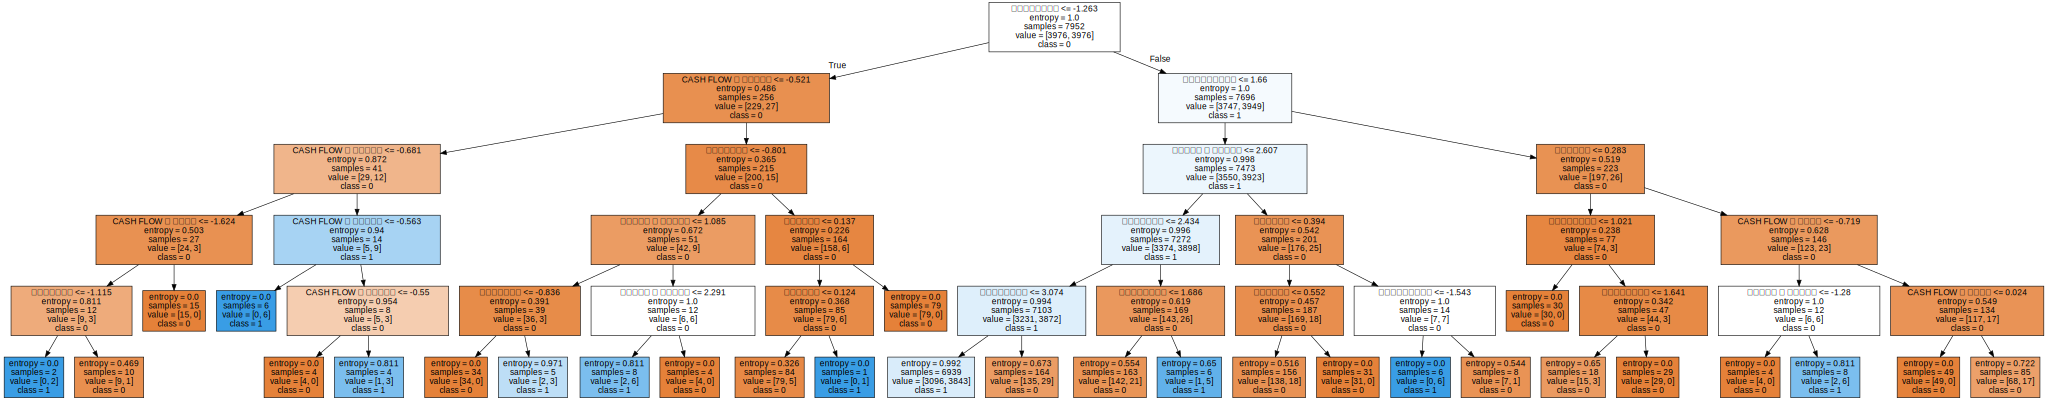

In [31]:
DT_vis(kosdaq_all, d_all)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8675916364937815

예측 데이터 정확도
accuracy score : 0.789
precision score : 0.140
recall score : 0.179
f1 score : 0.157
roc score : 0.522


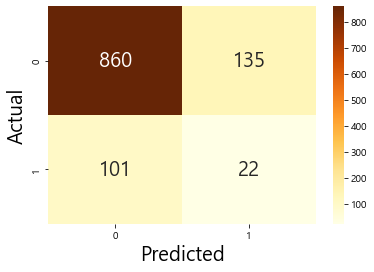

In [32]:
SVM(kosdaq_all, 'rbf')

In [33]:
# SVM(kosdaq_all, 'linear')

XGB

[23:40:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.056726094003242, 'silent': 1}
학습 데이터 정확도 :  0.8143081496647426

예측 데이터 정확도
accuracy score : 0.615
precision score : 0.127
recall score : 0.423
f1 score : 0.195
roc score : 0.531
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.44723    0.11628 0.60976   0.19531    0.51845
0.30000   0.50000    0.11484 0.52846  

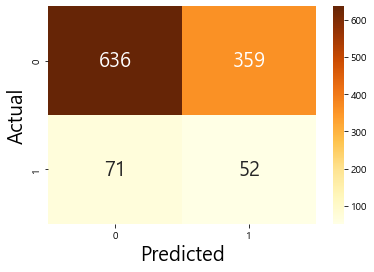

In [34]:
XGB(kosdaq_all)

##### 부정

Logistic Regression

최적 파라미터
 {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5871991220888105

예측 데이터 정확도
accuracy score : 0.570
precision score : 0.100
recall score : 0.444
f1 score : 0.164
roc score : 0.514
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.09492    0.09492 1.00000   0.17338    0.50000
0.30000   0.09492    0.09492 1.00000   0.17338    0.50000
0.40000   0.15244    0.09578 0.93939   0.17383    0.50465
0.50000   0.56951    0.10046 0.44444   0.16387    0.51354
0.60000   0.86865    0.10417 0.05051   0.06803    0.50248
0.70000   0.90412    0.00000 0.00000   0.00000    0.49947
0.80000   0.90508    0.00000 0.00000   0.00000    0.50000
0.90000   0.90508    0.00000 0.00000   0.00000    0.50000
None


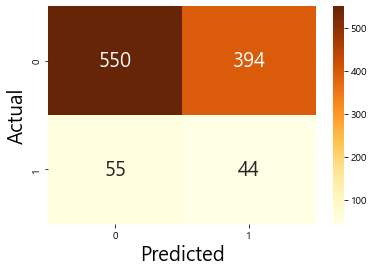

In [35]:
LG(kosdaq_bad)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6901305465092717

예측 데이터 정확도
accuracy score : 0.287
precision score : 0.094
recall score : 0.758
f1 score : 0.168
roc score : 0.497
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.27613    0.09406 0.76768   0.16759    0.49613
0.30000   0.28284    0.09488 0.76768   0.16889    0.49983
0.40000   0.28284    0.09488 0.76768   0.16889    0.49983
0.50000   0.28667    0.09434 0.75758   0.16779    0.49743
0.60000   0.89837    0.00000 0.00000   0.00000    0.49629
0.70000   0.89837    0.00000 0.00000   0.00000    0.49629
0.80000   0.89837    0.00000 0.00000   0.00000    0.49629
0.90000   0.90221    0.00000 0.00000   0.00000    0.49841
None


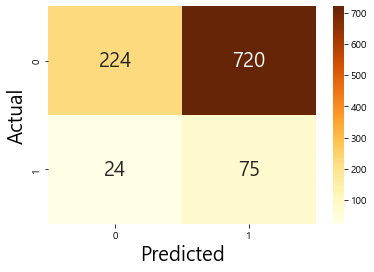

In [36]:
d_bad = DT(kosdaq_bad)

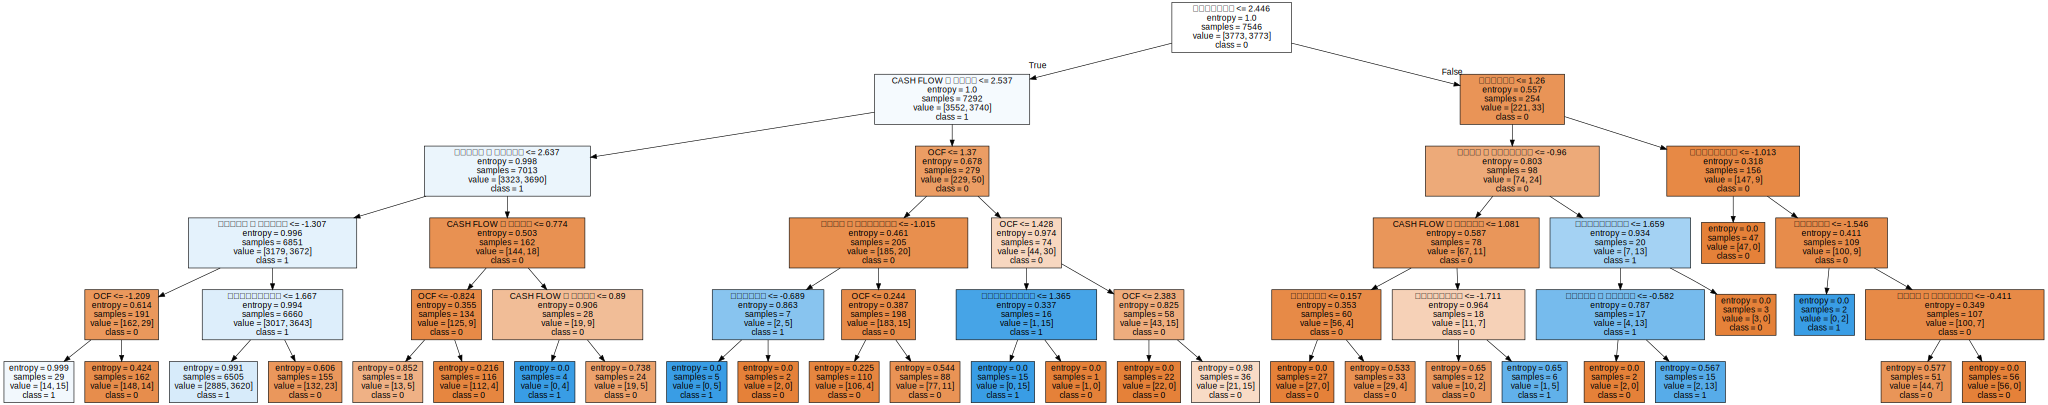

In [37]:
DT_vis(kosdaq_bad, d_bad)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.889467434119377

예측 데이터 정확도
accuracy score : 0.792
precision score : 0.090
recall score : 0.131
f1 score : 0.107
roc score : 0.496


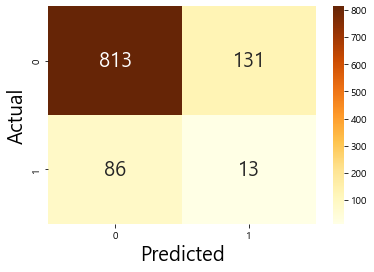

In [38]:
SVM(kosdaq_bad, 'rbf')

In [39]:
# SVM(kosdaq_bad, 'linear')

XGBoost

[23:49:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 9.51008064516129, 'silent': 1}
학습 데이터 정확도 :  0.8421275785703998

예측 데이터 정확도
accuracy score : 0.683
precision score : 0.113
recall score : 0.343
f1 score : 0.170
roc score : 0.531
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.53116    0.11000 0.55556   0.18364    0.54208
0.30000   0.58773    0.10875 0.46465   

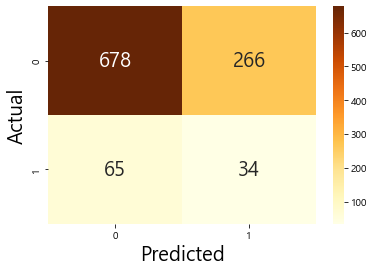

In [40]:
XGB(kosdaq_bad)

##### 건전

Logistic Regression

최적 파라미터
 {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.5704067818102907

예측 데이터 정확도
accuracy score : 0.600
precision score : 0.421
recall score : 0.667
f1 score : 0.516
roc score : 0.618
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.32000    0.32000 1.00000   0.48485    0.50000
0.30000   0.33333    0.32432 1.00000   0.48980    0.50980
0.40000   0.44000    0.35484 0.91667   0.51163    0.56618
0.50000   0.60000    0.42105 0.66667   0.51613    0.61765
0.60000   0.58667    0.18182 0.08333   0.11429    0.45343
0.70000   0.66667    0.33333 0.04167   0.07407    0.50123
0.80000   0.68000    0.00000 0.00000   0.00000    0.50000
0.90000   0.68000    0.00000 0.00000   0.00000    0.50000
None


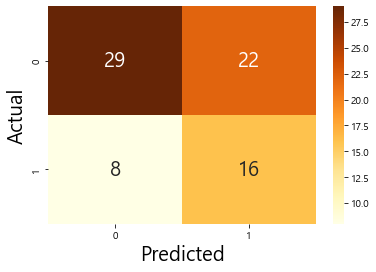

In [41]:
LG(kosdaq_good)

Decision Tree

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.6692016054101172

예측 데이터 정확도
accuracy score : 0.600
precision score : 0.412
recall score : 0.583
f1 score : 0.483
roc score : 0.596
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.58667    0.40000 0.58333   0.47458    0.58578
0.30000   0.58667    0.40000 0.58333   0.47458    0.58578
0.40000   0.58667    0.40000 0.58333   0.47458    0.58578
0.50000   0.60000    0.41176 0.58333   0.48276    0.59559
0.60000   0.61333    0.42424 0.58333   0.49123    0.60539
0.70000   0.64000    0.44444 0.50000   0.47059    0.60294
0.80000   0.60000    0.35000 0.29167   0.31818    0.51838
0.90000   0.60000    0.33333 0.25000   0.28571    0.50735
None


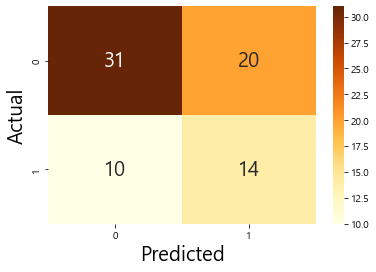

In [42]:
d_good = DT(kosdaq_good)

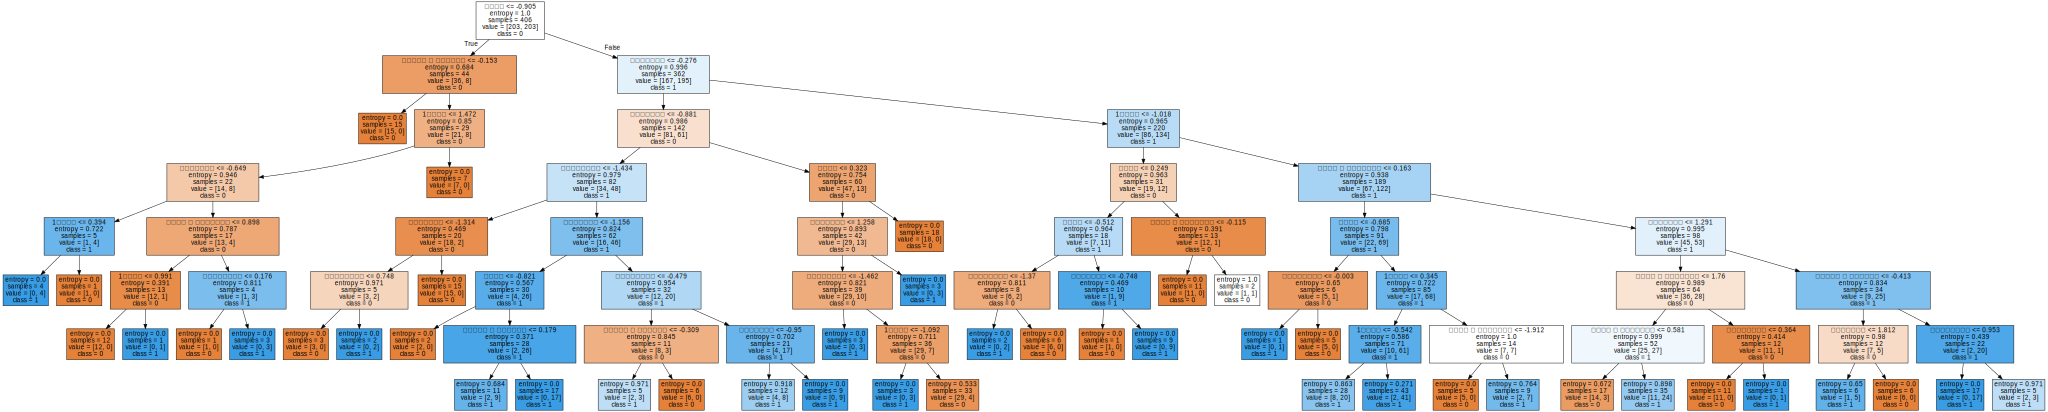

In [43]:
DT_vis(kosdaq_good, d_good)

SVM

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.8165805096429463

예측 데이터 정확도
accuracy score : 0.707
precision score : 0.583
recall score : 0.292
f1 score : 0.389
roc score : 0.597


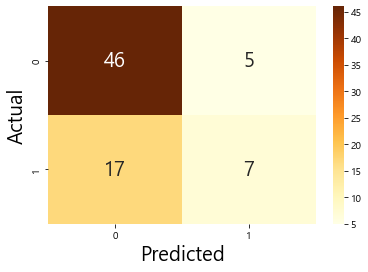

In [44]:
SVM(kosdaq_good, 'rbf')

In [45]:
# SVM(kosdaq_good, 'linear')

XGB

[23:50:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 2.0991735537190084, 'silent': 1}
학습 데이터 정확도 :  0.7521917660673677

예측 데이터 정확도
accuracy score : 0.627
precision score : 0.429
recall score : 0.500
f1 score : 0.462
roc score : 0.593
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.52000    0.36957 0.70833   0.48571    0.56985
0.30000   0.56000    0.39024 0.66667 

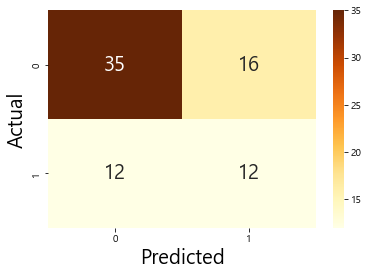

In [46]:
XGB(kosdaq_good)